In [1]:
from Bio import SeqIO
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md

In [24]:
def calculate_rmsd_mda(path_clusters, pdb_ref_path, high_ids):

    #trajectory=md.load(gmx_path + 'traj.xtc', top=gmx_path + 'traj.gro')
    clusters = []

    for filename in os.listdir(path_clusters):
        if filename.startswith('clus') and filename.endswith('.pdb'):
            cluster = md.load(os.path.join(path_clusters, filename))
            clusters.append(cluster)
    trajectory = clusters[0]
    for cluster in clusters[1:]:
        trajectory += cluster
    
    pdb_ref = md.load(pdb_ref_path)
  
    backbone_ref=[] 
    with open(pdb_ref_path, 'r') as file:
        for index, line in enumerate(file):
            columns = line.strip().split()
            if len(columns) >= 4 and columns[2] == "N":
                backbone_ref.append(index+1)
    
 #   helix = np.concatenate([np.arange(173,219,1), np.arange(266,301,1)]) # P08588
 #   helix = np.concatenate([np.arange(184,220,1), np.arange(270,300,1)]) # P13945
    
 #   loop = np.concatenate([np.arange(142,170,1), np.arange(300,308,1), np.arange(70,83,1)]) # P08588
  #  loop = np.concatenate([np.arange(153,184,1), np.arange(300,310,1), np.arange(80,90)]) # P13945
    loop = np.concatenate([np.arange(160,180,1), np.arange(280,290,1), np.arange(85,95,1)]) # P07550
    
    filters = high_ids # helix # loops 
 #   rmsd = md.rmsd(trajectory, pdb_ref, atom_indices=np.array(backbone_ref)[filters], ref_atom_indices=np.array(backbone_ref)[filters])
   
    rmsd = md.rmsd(trajectory, pdb_ref, atom_indices=np.array(backbone_ref), ref_atom_indices=np.array(backbone_ref))

    return rmsd

In [25]:
def main(name):
    
    path_full =  name + '/AF_full/'
    path_clusters =  name + '/AF_clusters/'
    output =  name + '/output/'
    ref_pdb = output + 'fullMSA_noH.pdb' 
    
    plddt = []
    size = []
    clu_ids = os.listdir(path_clusters)
    sorted_clu_ids = sorted(clu_ids, key=lambda x: int(x.split('_')[-1]) if '_' in x and x.split('_')[-1].isdigit() else float('inf'))

    for clu_id in sorted_clu_ids:
        
        path_cluster = path_clusters + clu_id +'/' 
        path_msa = name + '/clusters/' + clu_id + '.fasta'  
        
        cluster_pdb = path_clusters + clu_id + '/' + [file for file in os.listdir(path_cluster) if '_relaxed_rank_001' in file][0]
    
        plddt_val, high_ids = calculate_plddt(path_cluster, path_full)
        plddt.append(plddt_val)
        size.append(count_sequences_in_fasta(path_msa))
    
    rmsd = calculate_rmsd_mda(output, ref_pdb, high_ids)

    np.save(output+'rmsd.npy', rmsd)
    np.save(output+'plddt.npy', plddt)
    np.save(output+'size.npy', size)
    
    plot(sorted_clu_ids, rmsd, plddt, size, name)

In [26]:
def calculate_plddt(path_clusters, path_full):
    
    plddt_file = path_clusters + [file for file in os.listdir(path_clusters) if '_scores_rank_001' in file][0] 
    with open(plddt_file, 'r') as file:
        result_data = json.load(file)
    
    ref_plddt_file = path_full + [file for file in os.listdir(path_full) if '_scores_rank_001' in file][0] 
    with open(ref_plddt_file, 'r') as file:
        ref_data = json.load(file)

    plddt_local = result_data['plddt']
    high_ids = np.where(np.array(ref_data['plddt']) > 60)
    plddt_avg = np.mean(plddt_local)
    
    return plddt_avg, high_ids

In [27]:
def count_sequences_in_fasta(path_msa):
    sequence_count = sum(1 for _ in SeqIO.parse(path_msa, "fasta"))
    return sequence_count

In [28]:
def plot(clu_ids, rmsd, plddt, size, name):
    os.makedirs('results_figures', exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(7,3))

    sc = plt.scatter(clu_ids, rmsd, cmap='rainbow_r', s=size, c=plddt) 
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, label='plDDT')
    plt.title(name + ' (excluded low plDDT residues)') #+ ' extra_cellular oriented')
    plt.xlabel('cluster_id')
    plt.ylabel('RMSD from full MSA AlphaFold2 prediction')
    plt.xticks(rotation=90)
    plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.4)
    plt.xlim(left=-1,right=len(rmsd)+0.2)

    plt.tight_layout()
    plt.show()
  #  fig.savefig('results_figures/' + name+'_loop.png',dpi=500, format='png')

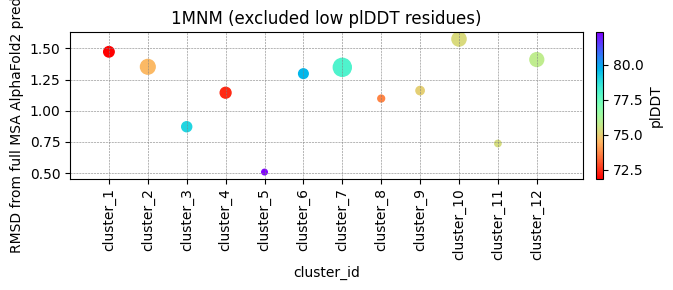

In [29]:
main('1MNM')